# Exploration 3. 고양이 수염 스티커 만들기

## ★프로젝트의 목표★
1. 카메라 앱 기능 구현이 정상적이면서, 원본 이미지에 스티커 사진이 잘 합성될 것
2. 고양이 수염이 적용될 위치를 정확한 좌표계산을 기반으로 이미지상의 얼굴에 잘 어울리게 배치하였을 것
3. 얼굴의 각도, 이미지의 밝기, 촬영거리 등 다양한 변수에 따른 영향도에 대해 분석할 것

### Step 1. 스티커 구하기

- flaticon 사이트에 공개된 고양이 수염 이미지를 다운로드하여 ~/AIFFEL/camera_sticker/images에 저장하였다.
- 스티커를 붙이는 데 사용할 원본 이미지는 저의 셀카가 아닌(ㅎㅎ.. 저는 못생겼어서 ㅠㅠ)..
- 블랙핑크 로제 님 사진을 하나 가져왔는데, 거기다 고양이 수염을 적절한 위치에 배치시켜 보도록 할 것이다.

### Step 2. 원본 이미지 읽어들이기, 색 보정하기

- dlib을 이용해서 얼굴의 boundering box 위치와 landmark의 위치를 찾는다.
- 이 절차를 수행하기 위해서는 먼저 원본 이미지를 읽어와야 한다.
- 이미지 처리를 위해 OpenCV와 노트북에 이미지를 출력하기 위한 matplotlib 패키지를 읽어와야 한다. 

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
print("🌫🛸")

🌫🛸


- matplotlib, dlib 등의 이미지 라이브러리에서는 RGB(빨강, 녹색, 파랑) 순으로 이미지 채널을 사용한다.
- OpenCV는 예외적으로 RGB 순이 아닌 BGR(파랑, 녹색, 빨강) 순으로 이미지 채널을 사용한다.
- 즉, 원본 사진에서 빨간색 부분은 파란색으로, 파란색 부분은 빨간색으로 바뀌어져 출력된다.
- 아래와 같이 로제 님 사진에 푸른빛이 감도는 이유는 OpenCV의 이러한 특징 때문이라고 할 수 있다.

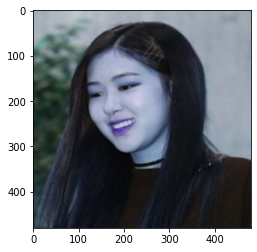

In [2]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (480, 480))    # 고양이 수염 스티커를 붙일 적절한 크기로 resize 하자.
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

- 이와 같이 푸른빛이 감돌고 있는 이미지를 원본 이미지로 변환하기 위해서 색 보정처리를 한다.
- OpenCV상에서 다룬 이미지를 다른 이미지 라이브러리를 활용하여 출력하려는 것이다.
- 아래 코드에 대한 나름의 이해
1. OpenCV 형태의 이미지를 원본이미지로 변환해 img_rgb에 할당한 후 이미지를 보여준다.
2. 이미지에 나타나는 축을 없애는 옵션을 추가한 후 다시 이미지를 보여준다.

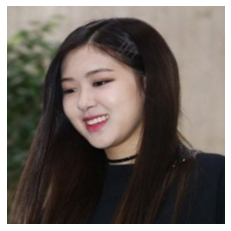

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')      ## 축을 없애는 옵션을 추가
plt.show()

### Step 3. 얼굴 검출하기

**< 진행 방법 >**
1. dlib을 활용하여 hog detector를 선언한다.
2. detector를 이용하여 얼굴의 boundering box를 추출한다.

**< 해당 Step에서 참고할 만한 개념 >**
- dlib은 RGB 이미지를 입력으로 받는다.
- 따라서 메서드 cvtcolor()를 이용하여 OpenCV의 BGR 이미지를 RGB로 변환하는 과정이 필요하다.
- **두 번째 코드블록(img_rgb로 시작함)의 detector_hog의 두 번째 파라미터 즉, '1'은 이미지 피라미드의 수를 나타낸다.**
- 이미지를 upsampling 방법을 이용해 크기를 키우는 작업을 이미지 피라미드라 한다.
- 이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있어 더 정확한 검출이 가능하다.

In [4]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


**아래는 찾은 얼굴을 화면에 출력한 결과이다.**

- dlib detector는 dlib.rectangles 타입의 객체를 반환한다.
- dlib.rectangles는 dlib.rectangle 객체의 배열 형태로 이루어진다.
- dlib.rectangle 객체는 left(), top(), right(), bottom(), height(), width() 등의 멤버 함수를 포함한다.

rectangles[[(97, 118) (283, 304)]]


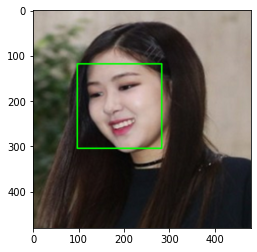

In [6]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### Step 4. 랜드마크 검출하기

**< 해당 Step에서 참고할 만한 개념 >**
- face landmark localization은 스티커를 섬세하게 적용하기 위해 이목구비의 위치를 추론하는 기술이다. 
- object keypoint estimation은 이러한 face landmark와 같이 객체 내부의 점을 찾는 기술이다.
- keypoint를 찾는 2가지 알고리즘
ⓐ top-down : boundering box를 먼저 찾고 box 내부의 keypoint를 예측
ⓑ bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화해서 box를 생성

**< Dlib landmark localization >**
- 잘려진 얼굴 이미지에서 아래 68개의 점에 대응하는 이목구비의 위치를 찾는다.
- Dlib은 ibug 300-W Dataset으로 학습한 pretrained model을 사용한다.
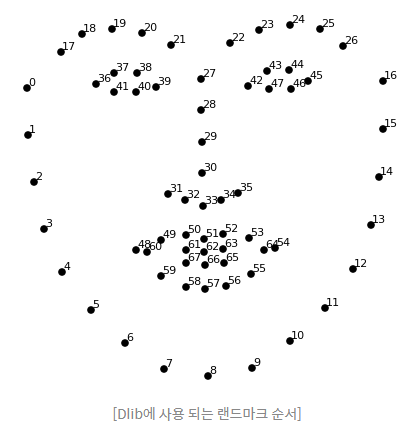

**사전에 압축을 풀어 저장한 landmark 모델을 불러오기로 한다.**

**landmark_predictor는 RGB 이미지와 dlib.rectangle을 입력받아서 dlib.full_object_detection을 반환한다.**

In [7]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [8]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))    ## tuple(x, y) 68개로 구성된 리스트이다.
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


**적용한 랜드마크를 이미지에 출력한 결과는 다음과 같다.**

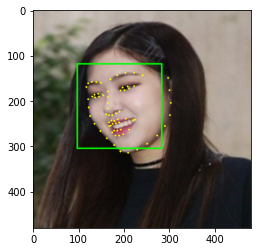

In [9]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### Step 5. 고양이 수염 스티커 적용하기

**< 해당 Step에서 참고할 만한 개념 >**
- 얼굴의 위치, 카메라의 거리 등에 따라 픽셀값이 달라질 수 있어, 비율로 계산해준다.

**ⓐ 좌표 확인하기**

In [26]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33])
    x = landmark[33][0]
    y = landmark[33][1]
    w = dlib_rect.width() - 7
    h = dlib_rect.width() - 7
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(174, 231)
(x,y) : (174,231)
(w,h) : (180,180)


**ⓑ 고양이 수염 스티커 이미지 읽어오기**

In [27]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(180, 180, 3)


**ⓒ x, y 좌표 조정하기**
- 원본 이미지에 스티커 이미지를 추가하기 위한 과정이다.
- refined된 y값은 음수이다.
- OpenCV의 데이터는 numpy ndarray 형태의 데이터를 사용한다.
- numpy ndarray에서는 음수 인덱스에 접근하지 못하게 되어있어, 음수 예외처리를 해준다.
- 다르게 말하면, 원본 이미지의 범위를 벗어나는 부분을 제거해준다는 의미와 같다.

In [28]:
refined_x = x + w // 2  # right
refined_y = y - h - 80     # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (264,-29)


**과정 ⓑ에서 resize된 크기에서 -y 크기만큼 스티커를 잘라낸다.**

In [29]:
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(151, 180, 3)


**top의 y 좌표는 원본 이미지의 경계값을 적용한다.**

In [30]:
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (264,0)


**이제 원본 이미지에 스티커를 적용하면 된다.**
- sticker_area 는 원본 이미지에서 스티커를 적용할 위치를 crop한 이미지이다.
- 스티커 이미지에서 사용할 부분은 색이 있는 부분으로 정한다.
- np.where()를 통해 img_sticker가 0이면 sticker_area를, 0이 아니면 img_sticker를 사용하도록 설정한다.

In [31]:
img_sticker.shape

(151, 180, 3)

In [32]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

**결과 이미지를 출력해보자.**

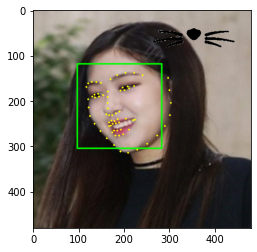

In [33]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 프로젝트 수행하면서 어려웠던 점?

- 지난 주말부터 본 프로젝트를 시작하면서 고양이 수염이 위치해야 할 코 밑이 아닌 이상한 위치에 계속 합성이 되어 어려움을 겪었습니다.
- landmark[33]의 x, y좌표와 refined_x, refined_y 등을 활용하다 보면 언젠가는 로제 님 코 밑에 귀여운 고양이 수염을 붙일 수 있겠죠? ㅠㅠ

## 변수에 따른 영향도에 대한 생각?

1. **얼굴의 각도** : 얼굴은 다양한 각도로 찍을 수가 있다. 어떤 각도로 얼굴을 찍느냐에 따라서 이미지에서 적절한 곳에 스티커를 붙일 수 있는 좌표값 또한 달라질 수 있다고 생각한다.
2. **이미지의 밝기** : 얼굴을 식별할 수 있을 정도의 밝기라면 같은 사진일 때 크게 문제가 되지는 않는다고 생각한다.
3. **촬영 거리** : 얼굴을 가까이에서 찍었거나, 멀리서 찍었거나에 따라 얼굴을 식별하는 boundering box의 크기가 커지거나 작아질 수 있고 그에 따른 각 landmark의 좌표도 달라질 수 있다.

## 프로젝트 회고

- 이번 프로젝트는 저에게 있어 상당히 어려운 프로젝트였습니다. 지난 토요일부터 프로젝트를 시작했으나 파라미터를 아무리 조절해도 눈썹 아래로 내려온 적이 단 한 번도 없어서 프로젝트를 하는 데 많은 고충이 있었습니다. 나중에 시간이 된다면 landmark 좌표계산을 다시 연구해서 꼭 로제 님의 코 밑에 고양이 수염을 붙이고 말겁니다!!!